### This notebook is for A Wilde's Project # of DATA 71200

# A description of the problem:
Given US Census data, the Current Population Survey, from 2009 with variables about income and work for people 65 and older, I would like to:

--> This is this notebook: **For the unsupervised project:** Try to indentify clusters of seniors

This notebook is cleaning and preparing the data for the supervised model project.
The data was exported from IPUMS CPS.
### Updated Cleaning from Project 1 Submission:
- Onehot encode before seperating Train and Test
- Scale after seperating Train and Test in different pipeline
- Gather meaningful feature names in cleaning process to use in visualization later
- Added imputer to handle missing values for continuous features

## In this notebook:
### Project 1:
#### 1) Loading the Data
##### Defining the Label 
#### 2) Cleaning the Data
#### 3) Applying Log
#### 4) Cleaning - one-hot encoding 
#### 5) Seperate out test set
#### 6) Standard Scaling of Test and Train
#### 7) Seperate out labels
### Project 2:
### 8) Logistic Regression
### 9) Decision Trees

In [2]:
import pandas as pd
import numpy as np

## Project 1
### 1) Load in the data

In [3]:
seniors_df = pd.read_csv("senior_data_2009_hr_t2.csv")

#### Getting a Label: 
- Calculate a combo field from EMPSTAT and WKSTAT 
- Transform to numeric

In [4]:
def combine_EMP_WKSTAT(empstat, wkstat):
    if empstat == "At work":
        if wkstat.find("Full-time") > -1:
            empwkstat = "Full-time"
        elif wkstat.find("Part-time") > -1:
            empwkstat = "Part-time"
        else:
            empwkstat = wkstat
    elif empstat.find("Unemployed") > -1:
            empwkstat = "Unemployed"
    else:
        empwkstat = empstat    
    return empwkstat

In [5]:
seniors_df['EMPWKSTAT'] = seniors_df.apply(lambda row: combine_EMP_WKSTAT(row['EMPSTAT'],row['WKSTAT']),axis=1)
seniors_df['EMPWKSTAT'].value_counts()

NILF, retired                     15865
Full-time                          1756
Part-time                          1715
NILF, unable to work               1084
NILF, other                         547
Unemployed                          225
Has job, not at work last week      210
Name: EMPWKSTAT, dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
seniors_empwkstat = seniors_df['EMPWKSTAT']
seniors_empwkstat_encoded = encoder.fit_transform(seniors_empwkstat)
seniors_df['EMPWKSTAT_Num']= pd.DataFrame(seniors_empwkstat_encoded)

In [7]:
seniors_df['EMPWKSTAT_Num'].value_counts()

3    15865
0     1756
5     1715
4     1084
2      547
6      225
1      210
Name: EMPWKSTAT_Num, dtype: int64

### 2) Data Cleaning
- Calculating New Values
- Dropping correlated values
- Handling Nulls

The following for calculating new values was adapted from the book *Hands-on Machine Learning* Chapter 2

#### Combining Attributes 
- for citizen percent of life **note this uses a hardcoded year value for this data (From 2009)**
- total passive income

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
# Class to combine attributes for Percent of Life one was Citizen and Total Passive Income
# Instantiation 
#   Input: 2 boolean values to add the two columns
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame 
class DF_CombinedAttributesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,add_citizen_percent_of_life = True, add_total_passive_inc = True):
        self.add_citizen_percent_of_life = add_citizen_percent_of_life
        self.add_total_passive_inc = add_total_passive_inc
    def fit(self, X, y = None):
        return self # nothing to do on fit
    def transform(self, X_df, y = None):
        #X is a data frame
        X_df_copy = X_df.copy(deep=True)
        if self.add_citizen_percent_of_life:
            X_df_copy['percent_of_life']=X_df_copy.apply(lambda row: (2009-int(row['YRIMMIG'][0:4]))/int(row['AGE']) if not pd.isna(row['YRIMMIG']) else 1,axis = 1)
        if self.add_total_passive_inc:
            X_df_copy['passive_inc'] = X_df_copy.apply(lambda row: row['INCTOT']-row['all_wages']-row['all_business_farm'],axis = 1)
        return X_df_copy

In [11]:
#test it
#adder = DF_CombinedAttributesTransformer()
#strat_seniors_train_combined_attribs = adder.transform(strat_seniors_train)
#strat_seniors_train_combined_attribs['percent_of_life'].value_counts()

#### Transformer for Dropping The Unnecssary Columns
This is also adapted from *Hands-on Machine Learning* Chapter 2

In [10]:
# Class to drop attributes
# Instantiation 
#   Input: a list of the columns to drop
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame - the dropped columns
class DF_DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        return X_df.drop(columns = self.columns_to_drop)

In [18]:
#test dropping class transformer
#dropper = DF_DropColumnsTransformer(['INCTOT', 'all_wages', 'INCLONGJ'])
#strat_seniors_train_combined_attribs_thinned = dropper.transform(strat_seniors_train_combined_attribs)
#strat_seniors_train_combined_attribs_thinned.columns

#### Class to address null values in the following remaining columns

In [11]:
null_counts = {}
for column in seniors_df.columns:
    count = seniors_df[column].isnull().sum()
    if count != 0:
        null_counts[column]= count


In [12]:
# Object of the keys and appropriate null values
null_values = {'PUBHOUS':'NIU','RENTSUB':'NIU','HISPAN':'NIU','SRCRETI1':'None','SRCRETI2':'None',
               'GOTVDISA':'NIU','GOTVOTHE':'NIU','GOTVPENS':'NIU','GOTVSURV':'NIU','all_survivor':0}

In [13]:
# Class to replace null values in given columns
# Instantiation 
#   Input: an object of the column names and their associated null value replacements
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame with the null values replaced
class DF_ReplaceNullValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, null_value_replacements):
        self.null_value_replacements = null_value_replacements
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        X_df_copy = X_df.copy(deep=True)
        for key, value in self.null_value_replacements.items():
            X_df_copy[key]=X_df_copy[key].apply(lambda x: value if pd.isna(x) else x)
        return X_df_copy

In [13]:
#test replace null values Transformer
#null_replacer = DF_ReplaceNullValuesTransformer(null_values)
#strat_seniors_train_combined_attribs_thinned_replaced = null_replacer.transform(strat_seniors_train_combined_attribs_thinned)
#null_counts = {}
#for column in strat_seniors_train_combined_attribs_thinned_replaced.columns:
#    count = strat_seniors_train_combined_attribs_thinned_replaced[column].isnull().sum()
#    if count != 0:
#        null_counts[column]= count
#null_counts

#### Pipeline of these Cleaning Steps
- DF_CombinedAttributesTransformer
- DF_DropColumnsTransformer
- DF_ReplaceNullValuesTransformer

Define the real values for: 
- Columns to drop
- null value replacements

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
# list of columns to drop:
columns_to_drop = ['FTOTVAL','INCTOT','INCOTHER','INCLONGJ','WKSWORK1','WHYPTLY','TAXINC','HOURWAGE','UNION',
                   'reported_inc_diff','all_wages','CLASSWKR','UHRSWORKT','SRCEARN','ratio_tax_income','multi_jobs',
                   'YRIMMIG','OCC','IND','CPSIDP','EMPSTAT','WKSTAT','all_business_farm']

# Object of the keys and appropriate null value replacements
null_value_replacements = {'PUBHOUS':'NIU','RENTSUB':'NIU','HISPAN':'NIU','SRCRETI1':'None','SRCRETI2':'None',
               'GOTVDISA':'NIU','GOTVOTHE':'NIU','GOTVPENS':'NIU','GOTVSURV':'NIU','all_survivor':0}

#### Run the Pipeline

In [16]:
df_cleaning_pipeline = Pipeline([
    ('combiner',DF_CombinedAttributesTransformer()),
    ('dropper',DF_DropColumnsTransformer(columns_to_drop)),
    ('null_replacer',DF_ReplaceNullValuesTransformer(null_value_replacements))
])
seniors_df_cleaned = df_cleaning_pipeline.fit_transform(seniors_df)

### 3) Applying logorithmic transform

because this is useful

Other transforms below, but not used

In [17]:
log_column_list=['INCDIVID','INCRETIR']

In [18]:
# Class to apply logorithmic scaling to a given list of columns
# Instantiation 
#   Input: a list of columns to scale logorithmically
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame with the null values replaced
class DF_GetLogValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_log):
        self.columns_to_log = columns_to_log
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        X_df_copy = X_df.copy(deep=True)
        for column in self.columns_to_log:
            X_df_copy[column]=X_df_copy[column].apply(lambda x: np.log(x+1))
        return X_df_copy

In [19]:
get_logs = DF_GetLogValuesTransformer(log_column_list)
seniors_df_cleaned_log = get_logs.fit_transform(seniors_df_cleaned)
seniors_df_cleaned_log.shape

(21402, 30)

### 4) Cleaning of Data:

#### Attribute One-hot (best done before splitting test) 
Adapted from *Hands-on Machine Learning* Chapter 2

In [20]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [21]:
# define columns for numeric vs categorical pipelines
numeric_columns = ['HOUSRET','AGE','INCSS','INCWELFR','INCRETIR','INCSSI','INCDIVID','INCALIM',
                   'all_disability','all_survivor','percent_of_life','passive_inc','INCRENT']
categor_columns = ['OWNERSHP','PUBHOUS','RENTSUB','SEX','RACE','MARST','CITIZEN','HISPAN','EDUC','SRCRETI1',
                  'GOTVDISA','GOTVOTHE','GOTVPENS','GOTVSURV','SRCRETI2']
passthrough_numeric = ['EMPWKSTAT_Num']
passthrough_categor = ['EMPWKSTAT']

In [22]:
# Helper transformer to seperate out the given columns of a DataFrame
# Instantiation 
#   Input: a list of the columns to select
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: NP Array with just the selected columns
class DF_NP_Column_Selector(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_select):
        self.columns_to_select = columns_to_select
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        return X_df[self.columns_to_select].to_numpy()
    def get_feature_names(self):
        return self.columns_to_select

In [23]:
categor_pipeline= Pipeline([
    ('selector', DF_NP_Column_Selector(categor_columns)),
    ('1hot_encoder', OneHotEncoder())
])

#### One hot encode the categorical values

In [24]:
categor_cols = categor_pipeline.fit_transform(seniors_df_cleaned_log)
categor_cols.shape

(21402, 87)

In [25]:
categor_names = categor_pipeline['1hot_encoder'].get_feature_names()
len(categor_names)

87

#### Re-join to orginal data

In [26]:
seniors_to_join= seniors_df_cleaned.drop(columns=categor_columns)
curr_columns = seniors_to_join.columns
np_seniors_to_join=seniors_to_join.to_numpy()

In [27]:
categor_cols=categor_cols.toarray()

In [28]:
seniors_np_categor_processed = np.column_stack((np_seniors_to_join,categor_cols))

In [29]:
seniors_df_categor_processed = pd.DataFrame(seniors_np_categor_processed, columns = [*curr_columns,*categor_names])

#### Seperate out test and train before standard scaling

### 5) Seperate out a test set
(stratified by employment status)

Adapted from Hands On Machine Learning book

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=17)
for train_index, test_index in split.split(seniors_df_categor_processed, seniors_df_categor_processed['EMPWKSTAT_Num']):
    strat_seniors_train = seniors_df_categor_processed.loc[train_index]
    strat_seniors_test = seniors_df_categor_processed.loc[test_index]

In [31]:
strat_seniors_train['EMPWKSTAT'].value_counts() /len(strat_seniors_train)

NILF, retired                     0.741262
Full-time                         0.082051
Part-time                         0.080120
NILF, unable to work              0.050651
NILF, other                       0.025544
Unemployed                        0.010529
Has job, not at work last week    0.009844
Name: EMPWKSTAT, dtype: float64

In [32]:
strat_seniors_test['EMPWKSTAT'].value_counts() /len(strat_seniors_test)

NILF, retired                     0.741357
Full-time                         0.082041
Part-time                         0.080172
NILF, unable to work              0.050645
NILF, other                       0.025603
Unemployed                        0.010465
Has job, not at work last week    0.009718
Name: EMPWKSTAT, dtype: float64

In [33]:
strat_seniors_train.shape

(16051, 102)

In [34]:
strat_seniors_test.shape

(5351, 102)

### 6) Standard Scaling

In [35]:
from sklearn.impute import SimpleImputer
numeric_pipeline = Pipeline([
    ('selector', DF_NP_Column_Selector(numeric_columns)),
    ('std_scaler', StandardScaler()),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0))
])

In [36]:
train_numeric_cols = numeric_pipeline.fit_transform(strat_seniors_train)
train_numeric_cols.shape

(16051, 13)

In [37]:
test_numeric_cols = numeric_pipeline.fit_transform(strat_seniors_test)
test_numeric_cols.shape

(5351, 13)

##### Rejoin to the original data
- for Train
- for Test

In [38]:
strat_seniors_train_to_join= strat_seniors_train.drop(columns=numeric_columns)
curr_columns = strat_seniors_train_to_join.columns
np_strat_seniors_train_to_join=strat_seniors_train_to_join.to_numpy()

In [39]:
strat_seniors_train_prepared = np.column_stack((np_strat_seniors_train_to_join,train_numeric_cols))

In [40]:
seniors_df_train = pd.DataFrame(strat_seniors_train_prepared, columns = [*curr_columns,*numeric_columns])

In [41]:
strat_seniors_test_to_join= strat_seniors_test.drop(columns=numeric_columns)
curr_columns = strat_seniors_test_to_join.columns
np_strat_seniors_test_to_join=strat_seniors_test_to_join.to_numpy()

In [42]:
strat_seniors_test_prepared = np.column_stack((np_strat_seniors_test_to_join,test_numeric_cols))

In [43]:
seniors_df_test = pd.DataFrame(strat_seniors_test_prepared, columns = [*curr_columns,*numeric_columns], )

##### Drop the label Num value used in earlier visualizations and 

In [44]:
seniors_df_train=seniors_df_train.drop(columns='EMPWKSTAT_Num')
seniors_df_test=seniors_df_test.drop(columns='EMPWKSTAT_Num')

### 7) Seperate the labels 

In [45]:
# Seperate out the labels
# Instantiation 
#   Input: the label column
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: Dataframe without the labels, NP array of the labels
class DF_NP_Cat_Label_Seperator(BaseEstimator, TransformerMixin):
    def __init__(self, label_column):
        self.label_column = label_column
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        labels_np = X_df[self.label_column].to_numpy()
        X_df_no_labels = X_df.drop(columns=self.label_column)
        return X_df_no_labels, labels_np

In [46]:
label_seperator = DF_NP_Cat_Label_Seperator('EMPWKSTAT')
seniors_df_train_nol, train_labels = label_seperator.transform(seniors_df_train)
seniors_df_test_nol, test_labels = label_seperator.transform(seniors_df_test) 

In [47]:
seniors_np_train_nol = seniors_df_train_nol.to_numpy()

In [48]:
seniors_np_test_nol = seniors_df_test_nol.to_numpy()

## Project 3:

## 8) Principal Component Analysis
- How many compenents needed to ID 95% of variance
- Evaluation of best performing model from Project 2


### Get the Principal Components

In [49]:
from sklearn.decomposition import PCA

In [50]:
pca = PCA(n_components=0.95)
pca.fit(seniors_np_train_nol)
seniors_train_pca = pca.transform(seniors_np_train_nol)
seniors_test_pca = pca.transform(seniors_np_test_nol)
print("Original features train: {}".format(str(seniors_np_train_nol.shape[1])))
print("Principal components for 95% of Variance train: {}".format(str(seniors_train_pca.shape[1])))

Original features train: 100
Principal components for 95% of Variance train: 26


### Evaluation of best performing model from Project 2 (Random Forest)

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [52]:
forest = RandomForestClassifier(max_features=20, min_samples_leaf= 5, n_estimators=50)
forest.fit(seniors_np_train_nol, train_labels)
print("Accuracy on orig training set: {:.3f}".format(forest.score(seniors_np_train_nol, train_labels)))
print("Accuracy on test set: {:.3f}".format(forest.score(seniors_np_test_nol, test_labels)))
forest_pca=RandomForestClassifier(max_features=20, min_samples_leaf= 5, n_estimators=50)
forest_pca.fit(seniors_train_pca, train_labels)
print("Accuracy on pca training set: {:.3f}".format(forest_pca.score(seniors_train_pca, train_labels)))
print("Accuracy on pca test set: {:.3f}".format(forest_pca.score(seniors_test_pca, test_labels)))
print("Precision Report on Orig data:")
print(classification_report(test_labels, forest.predict(seniors_np_test_nol)))
print("Precision Report on PCA-ed data:")
print(classification_report(test_labels, forest_pca.predict(seniors_test_pca)))

Accuracy on orig training set: 0.778
Accuracy on test set: 0.756
Accuracy on pca training set: 0.828
Accuracy on pca test set: 0.751
Precision Report on Orig data:


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                precision    recall  f1-score   support

                     Full-time       0.50      0.29      0.36       439
Has job, not at work last week       0.00      0.00      0.00        52
                   NILF, other       0.00      0.00      0.00       137
                 NILF, retired       0.77      0.99      0.86      3967
          NILF, unable to work       0.58      0.03      0.05       271
                     Part-time       1.00      0.00      0.00       429
                    Unemployed       0.00      0.00      0.00        56

                      accuracy                           0.76      5351
                     macro avg       0.41      0.19      0.18      5351
                  weighted avg       0.72      0.76      0.67      5351

Precision Report on PCA-ed data:
                                precision    recall  f1-score   support

                     Full-time       0.47      0.27      0.34       439
Has job, not at work last w

The PCA feature reduction does not improve the performance of my best performing model from project 2, it is slightly less

### 9) Clustering on regular and reduced data
- k-Means
- Aggolmerate/Hierarchical
- DBSCAN

### k-Means

#### No PCA first

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import mglearn

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


#### Use "elbow plot" to ID right number of clusters for non-pca data

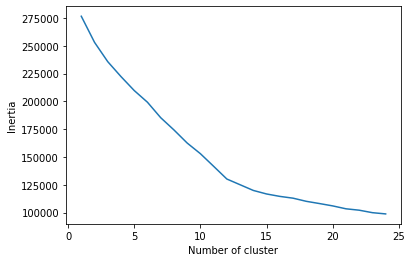

In [54]:
inertiaVals = {}

for k in range(1, 25):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(seniors_np_train_nol)
    inertiaVals[k] = kmeansTmp.inertia_ 
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [68]:
kmeans = KMeans(n_clusters=12)
kmeans.fit(seniors_np_train_nol)
assignments=kmeans.labels_

In [69]:
column_names=seniors_df_train_nol.columns.values

Text(0, 0.5, 'INCSS')

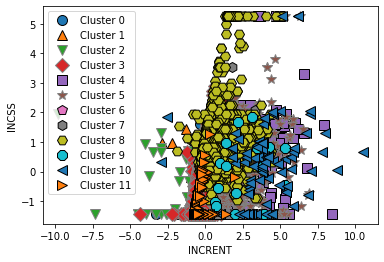

In [77]:
mglearn.discrete_scatter(seniors_np_train_nol[:, list(column_names).index('passive_inc')], seniors_np_train_nol[:, list(column_names).index('INCSS')], assignments)
plt.legend(["Cluster 0", "Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7","Cluster 8", "Cluster 9", "Cluster 10","Cluster 11"], loc="best")
plt.xlabel("passive_inc")
plt.ylabel("INCSS")

#### PCA-ed data
#### Use "Elbow plot" of inertia to ID number of clusters with PCA data

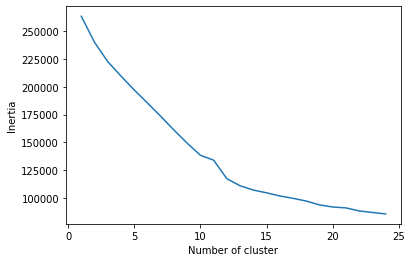

In [78]:
inertiaVals = {}

for k in range(1, 25):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(seniors_train_pca)
    inertiaVals[k] = kmeansTmp.inertia_ 
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [79]:
kmeans_pca = KMeans(n_clusters=12)
kmeans_pca.fit(seniors_train_pca)
assignments_pca=kmeans.labels_

Text(0, 0.5, 'Feature 0')

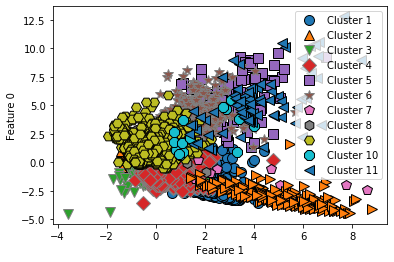

In [82]:
mglearn.discrete_scatter(seniors_train_pca[:, 1], seniors_train_pca[:, 0], assignments_pca)
plt.legend(["Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7","Cluster 8", "Cluster 9", "Cluster 10","Cluster 11"], loc="best")
plt.xlabel("Feature 1")
plt.ylabel("Feature 0")

###  Calculate both Adjusted Rand Index and Silhouette Coefficient for both pca and non-pca
Adapted from Class 12 Notebook

In [184]:
from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

# make a list of the clusters
# data - make a list of the data to use
data_list = [
        {
            'dataset': seniors_np_train_nol,
            'feature1': seniors_np_train_nol[:, list(column_names).index('passive_inc')], 
            'feature2': seniors_np_train_nol[:, list(column_names).index('INCSS')],
            'label2': '',
            'label1': 'Random State - Not'
        },
        {
            'dataset': seniors_np_train_nol,
            'feature1': seniors_np_train_nol[:, list(column_names).index('passive_inc')], 
            'feature2': seniors_np_train_nol[:, list(column_names).index('INCSS')],
            'label2': 'No PCA',
            'label1': ''
        },
        {
            'dataset': seniors_train_pca, 
            'feature1': seniors_train_pca[:, 1], 
            'feature2': seniors_train_pca[:, 0], 
            'label2': 'PCA',
            'label1' : ''
        }
        ]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(seniors_np_train_nol))
data_list[0]['clusters']=random_clusters



#### Evaluate first with the "elbow" value for clusters and then with the number of groups in the "label"

In [194]:
for data in data_list[1:]:
    clusters = KMeans(n_clusters=12).fit_predict(data['dataset'])
    data['clusters'] = clusters

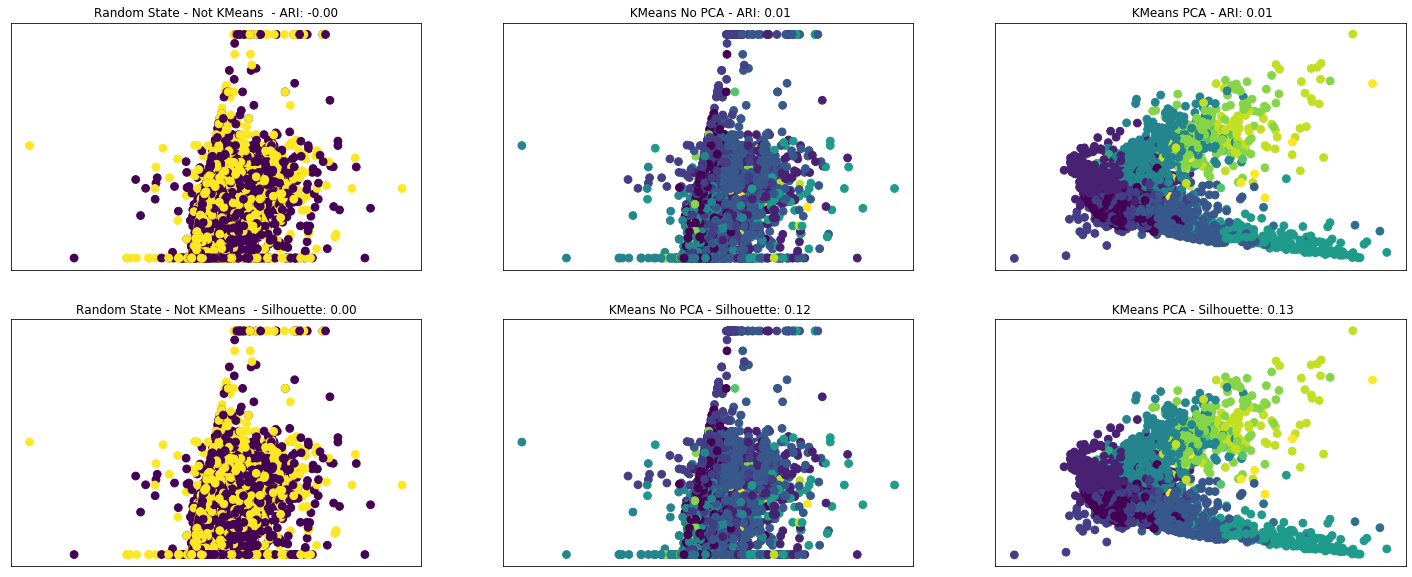

In [195]:
fig, axes = plt.subplots(2, 3, figsize=(25, 10),
                         subplot_kw={'xticks': (), 'yticks': ()})

y = 0
x = 0

for i, data in enumerate(data_list):
    # plot the cluster assignments and cluster centers
    axes[x,i].scatter(data['feature1'], data['feature2'], c=data['clusters'],
                s=60)
    axes[x,i].set_title("{} KMeans {} - ARI: {:.2f}".format(data['label1'], data['label2'],
                                           adjusted_rand_score(train_labels, data['clusters'])))
x=1 #new scorer
for i, data in enumerate(data_list):
    # plot the cluster assignments and cluster centers
    axes[x,i].scatter(data['feature1'], data['feature2'], c=data['clusters'],
             s=60)
    axes[x,i].set_title("{} KMeans {} - Silhouette: {:.2f}".format(data['label1'], data['label2'],
                                           silhouette_score(data['dataset'], data['clusters'])))


In [196]:
#only have 7 categories in the "label"
for data in data_list[1:]:
    clusters = KMeans(n_clusters=7).fit_predict(data['dataset'])
    data['clusters'] = clusters

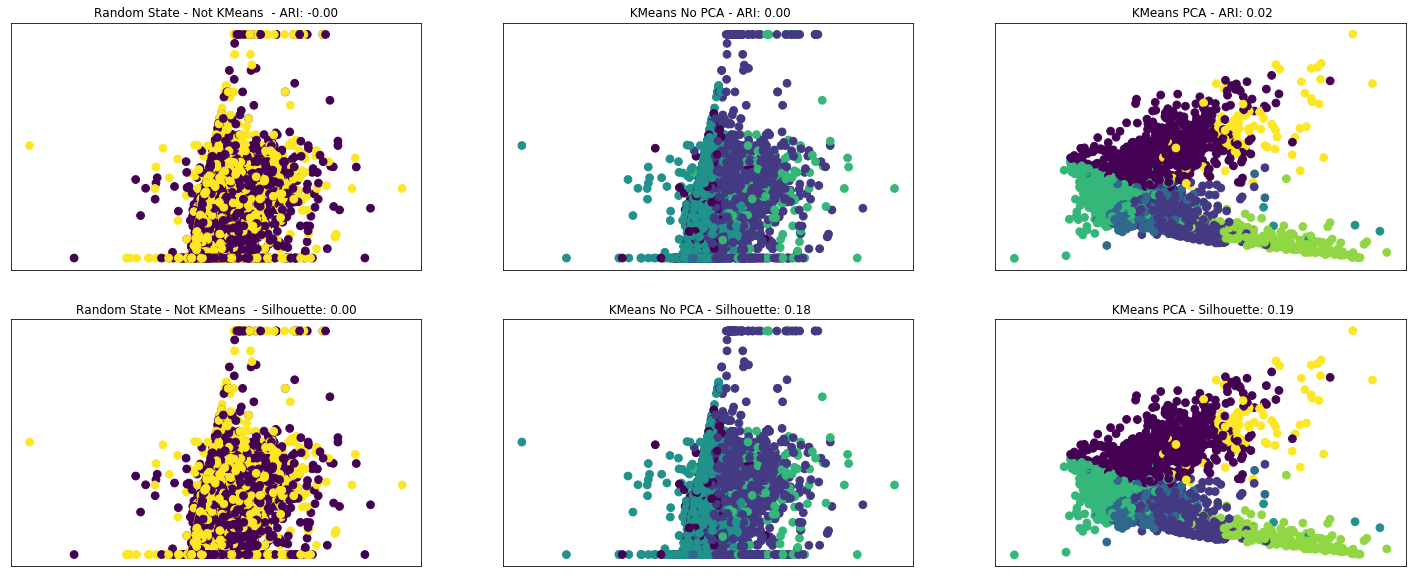

In [197]:
fig, axes = plt.subplots(2, 3, figsize=(25, 10),
                         subplot_kw={'xticks': (), 'yticks': ()})

y = 0
x = 0

for i, data in enumerate(data_list):
    # plot the cluster assignments and cluster centers
    axes[x,i].scatter(data['feature1'], data['feature2'], c=data['clusters'],
                s=60)
    axes[x,i].set_title("{} KMeans {} - ARI: {:.2f}".format(data['label1'], data['label2'],
                                           adjusted_rand_score(train_labels, data['clusters'])))
x=1 #new scorer
for i, data in enumerate(data_list):
    # plot the cluster assignments and cluster centers
    axes[x,i].scatter(data['feature1'], data['feature2'], c=data['clusters'],
             s=60)
    axes[x,i].set_title("{} KMeans {} - Silhouette: {:.2f}".format(data['label1'], data['label2'],
                                           silhouette_score(data['dataset'], data['clusters'])))

## Agglomerative Clustering

#### No PCA

Text(0, 0.5, 'INCSS')

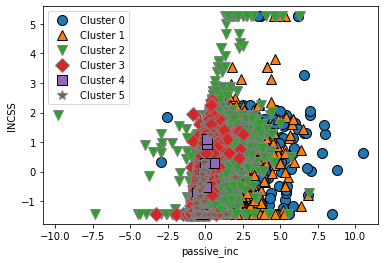

In [159]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=6)
clusters = agg.fit_predict(seniors_np_train_nol)
mglearn.discrete_scatter(seniors_np_train_nol[:, list(column_names).index('passive_inc')], seniors_np_train_nol[:, list(column_names).index('INCSS')], clusters)
plt.legend(["Cluster 0", "Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7","Cluster 8", "Cluster 9", "Cluster 10","Cluster 11"], loc="best")
plt.xlabel("passive_inc")
plt.ylabel("INCSS")

### PCA-ed data
Agglomerative Clustering

Text(0, 0.5, 'Feature 0')

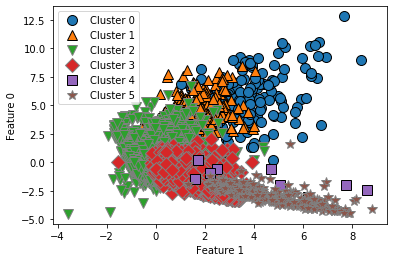

In [160]:
clusters = agg.fit_predict(seniors_train_pca)
mglearn.discrete_scatter(seniors_train_pca[:, 1], seniors_train_pca[:, 0], clusters)
plt.legend(["Cluster 0", "Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7","Cluster 8", "Cluster 9", "Cluster 10","Cluster 11"], loc="best")
plt.xlabel("Feature 1")
plt.ylabel("Feature 0")

#### update the clusters and run scoring chart for Adjusted Rand Index and Silhouette Coefficient of Agglomerative Clustering

In [204]:
for data in data_list[1:]:
    clusters = AgglomerativeClustering(n_clusters=7).fit_predict(data['dataset'])
    data['clusters'] = clusters

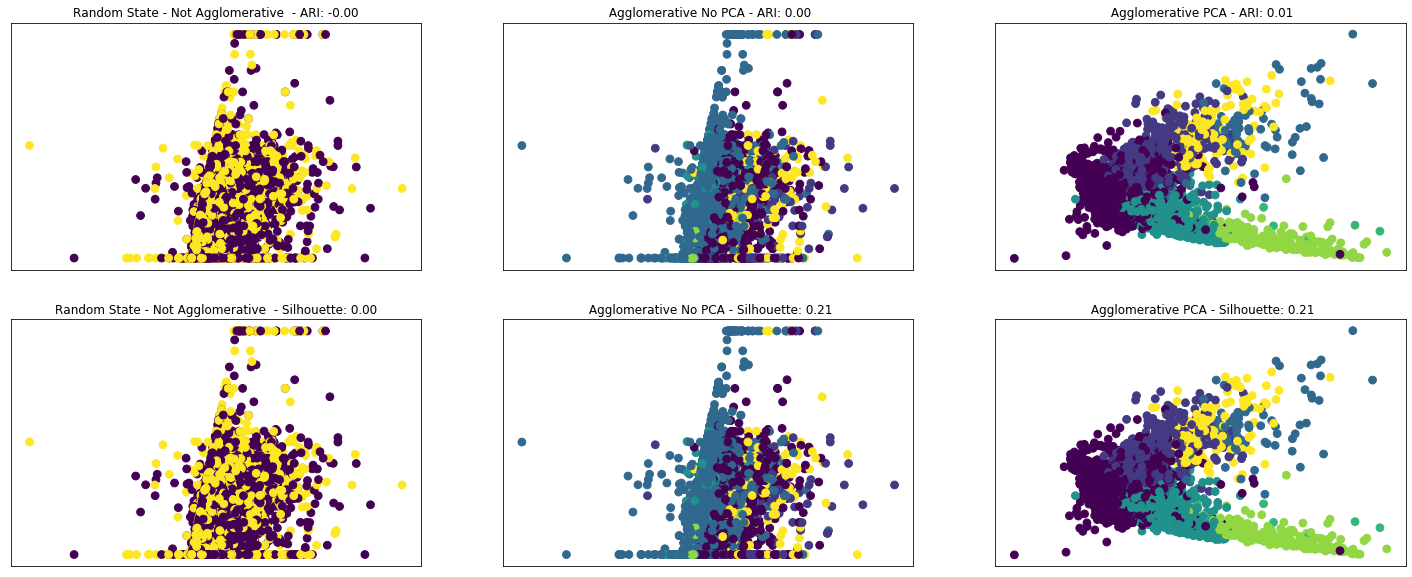

In [205]:
fig, axes = plt.subplots(2, 3, figsize=(25, 10),
                         subplot_kw={'xticks': (), 'yticks': ()})

y = 0
x = 0

for i, data in enumerate(data_list):
    # plot the cluster assignments and cluster centers
    axes[x,i].scatter(data['feature1'], data['feature2'], c=data['clusters'],
            s=60)
    axes[x,i].set_title("{} Agglomerative {} - ARI: {:.2f}".format(data['label1'], data['label2'],
                                           adjusted_rand_score(train_labels, data['clusters'])))
x=1 #new scorer
for i, data in enumerate(data_list):
    # plot the cluster assignments and cluster centers
    axes[x,i].scatter(data['feature1'], data['feature2'], c=data['clusters'],
            s=60)
    axes[x,i].set_title("{} Agglomerative {} - Silhouette: {:.2f}".format(data['label1'], data['label2'],
                                           silhouette_score(data['dataset'], data['clusters'])))

### DBSCAN

#### Non-PCA-ed data

Text(0, 0.5, 'INCSS')

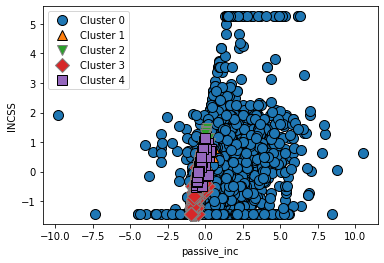

In [200]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(min_samples=30,eps=0.6)
clusters = dbscan.fit_predict(seniors_np_train_nol)
mglearn.discrete_scatter(seniors_np_train_nol[:, list(column_names).index('passive_inc')], seniors_np_train_nol[:, list(column_names).index('INCSS')], clusters)
plt.legend(["Cluster 0", "Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7","Cluster 8", "Cluster 9", "Cluster 10","Cluster 11"], loc="best")
plt.xlabel("passive_inc")
plt.ylabel("INCSS")

####  PCA-ed data
DB Scan

Text(0, 0.5, 'Feature 0')

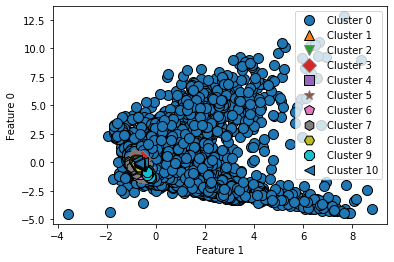

In [201]:
clusters= dbscan.fit_predict(seniors_train_pca)
mglearn.discrete_scatter(seniors_train_pca[:, 1], seniors_train_pca[:, 0], clusters)
plt.legend(["Cluster 0", "Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7","Cluster 8", "Cluster 9", "Cluster 10","Cluster 11"], loc="best")
plt.xlabel("Feature 1")
plt.ylabel("Feature 0")

#### update the clusters and re-run the scoring chart of Adjusted Rand Index and Silhouette Coefficient for DBScan

In [202]:
for data in data_list[1:]:
    clusters = DBSCAN(min_samples=30,eps=0.6).fit_predict(data['dataset'])
    data['clusters'] = clusters

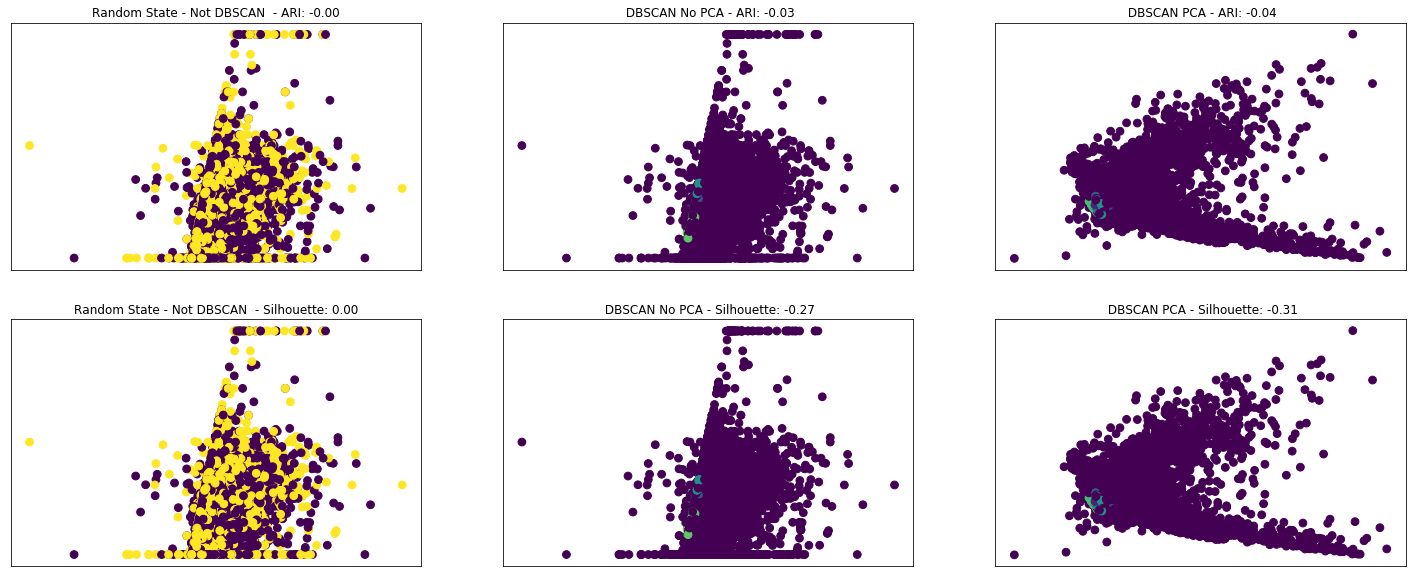

In [203]:
fig, axes = plt.subplots(2, 3, figsize=(25, 10),
                         subplot_kw={'xticks': (), 'yticks': ()})

y = 0
x = 0

for i, data in enumerate(data_list):
    # plot the cluster assignments and cluster centers
    axes[x,i].scatter(data['feature1'], data['feature2'], c=data['clusters'],
            s=60)
    axes[x,i].set_title("{} DBSCAN {} - ARI: {:.2f}".format(data['label1'], data['label2'],
                                           adjusted_rand_score(train_labels, data['clusters'])))
x=1 #new scorer
for i, data in enumerate(data_list):
    # plot the cluster assignments and cluster centers
    axes[x,i].scatter(data['feature1'], data['feature2'], c=data['clusters'],
            s=60)
    axes[x,i].set_title("{} DBSCAN {} - Silhouette: {:.2f}".format(data['label1'], data['label2'],
                                           silhouette_score(data['dataset'], data['clusters'])))

## Notes from Project 3:
PCA does not improve the performance of my best model from project 2, it's basically the same or slightly less.

In general the PCA data performed basically the same as the standardized data-set, usually just marginally better.
My data is questionably clusterable, or at least not along the label value. 

**With k Means** - Following the "elbow" value for k-Means clustering results in 12 clusters. This scores dismally in on the Adjusted Rand Index, basically the same result as random values. The silhoutte is not great either at .13 for the PCA-ed value and .12 for the regular standardized data-set, indicating a lot of overlap between my clusters

If I use the same number of clusters as there are unique values of labels, the non-PCA-ed values score .01 worse on the ARI and the PCA-ed values score .01 higher, for a whopping .02 accuracy. The silhouette scores for both increase by about .05.

**With Agglomerative Clustering** - this was the most performant clustering, but that isn't saying much. I used 7 clusters again as the input because this is the number of labels. Still basically no scoring on the ARI, and only up to .21 on the silhouette coefficient. 

**With DB Scan** - I tried many different variations of min group size between 50 and 1 and eps between 1 and .001, but this was the worst performing clustering across all of them. It manages a negative ARI of .04 and negative Silhouette coefficents of -.27 for the non-PCA and -.31 for the PCA. Given that I am not comparing these to labels I am not sure how to interpret the negative silhouette coefficient other than very not-dense clusters.